# Sediment resuspension parameterization

Based on tidal speeds from Jacqui-Lee

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import xarray as xr
import scipy.io

%matplotlib inline

##### Parameters

In [3]:
imin, imax = 1099, 2179
jmin, jmax = 159, 799

isize = imax-imin
jsize = jmax-jmin

##### Load files:

In [4]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

cond2      = (mesh_bathy > 0.1)
bathy_masked = np.ma.masked_where(cond2, mesh_bathy)

In [5]:
mat         = scipy.io.loadmat('/ocean/brogalla/GEOTRACES/data/mean_tide_speed.mat')
tidal_speed = mat['mean_speed']

ts_mesh     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/hsquare.nc')
ts_lons     = np.array(ts_mesh.variables['nav_lon'])
ts_lats     = np.array(ts_mesh.variables['nav_lat'])

In [6]:
tmask = np.array(mesh.variables['tmask'])[0,:,:,:]

##### Functions

In [10]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate Mn model output from Marco to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : Mn model lons/lats
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D Mn model variable
    '''
    from scipy.interpolate import griddata

    LatLonPair = (nav_lon.flatten(), nav_lat.flatten())
    var_out = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='nearest')
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

In [11]:
def find_closest_model_point(
    lon, lat, model_lons, model_lats, grid='NEMO', land_mask=None,
    tols={
        'NEMO': {'tol_lon': 0.05, 'tol_lat': 0.0388},
        'GEM2.5': {'tol_lon': 0.016, 'tol_lat': 0.012},
        }
):

    if grid not in tols:
        raise KeyError(
            'The provided grid type is not in tols. '
            'Use another grid type or add your grid type to tols.')

    # Search for a grid point with longitude and latitude within tolerance of measured location
    j_list, i_list = np.where(
        np.logical_and(
            (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
                            model_lons < lon + tols[grid]['tol_lon'])),
            (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
                            model_lats < lat + tols[grid]['tol_lat']))
        )
    )

    if len(j_list) == 0:
        # If including points outside of domain:
        return np.nan, np.nan
    try:
        j, i = map(np.asscalar, (j_list, i_list))
    except ValueError:
        # Several points within tolerance
        # Calculate distances for all and choose the closest
        lons = [model_lons[j_list[n], i_list[n]] for n in range(len(j_list))]
        lats = [model_lats[j_list[n], i_list[n]] for n in range(len(j_list))]
        dists = haversine(
            np.array([lon] * i_list.size), np.array([lat] * j_list.size),
            lons, lats)
        n = dists.argmin()
        j, i = map(np.asscalar, (j_list[n], i_list[n]))

    # If point is on land and land mask is provided
    # try to find closest water point
    if land_mask is None or not land_mask[j, i]:
        return j, i
    try:
        return _spiral_search_for_closest_water_point(
            j, i, land_mask, lon, lat, model_lons, model_lats)
    except ValueError:
        raise ValueError(
            'lat/lon on land and no nearby water point found')


def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [12]:
def find_index_ANHA12(transect_lons, transect_lats, ANHA12sub_lon=mesh_lon, ANHA12sub_lat=mesh_lat):
    # input:   ANHA12sub_lon, ANHA12sub_lat --- 570x600 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    
    if isinstance(transect_lons,float):
        i, j = find_closest_model_point(transect_lons, transect_lats, ANHA12sub_lon, ANHA12sub_lat)
        transect_i = i
        transect_j = j
    else:
        for k in range(0,len(transect_lons)):
            i, j = find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12sub_lon, ANHA12sub_lat)
            transect_i = np.append(transect_i, i)
            transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

##### Calculations

In [13]:
tidal_speed_ANHA12 = interp_np(ts_lons, ts_lats, tidal_speed, mesh_lon, mesh_lat)
tidal_speed_ANHA12[np.isnan(tidal_speed_ANHA12)] = 0
tidal_speed_ANHA12[tidal_speed_ANHA12 < 0.01] = 0 # mask tidal speeds slower than 1 cm/s

In [14]:
# alpha_0 = 0.3e-6*9*0.8
gamma   = 0.065
alpha_0 = 0.3e-6*9*0.8*0.055/gamma
old_erosion_rate     = alpha_0*tidal_speed_ANHA12**2
log_old_erosion_rate = np.log10(old_erosion_rate)

new_erosion_rate     = alpha_0*gamma*(1-np.exp(-tidal_speed_ANHA12**2/gamma))
log_new_erosion_rate = np.log10(new_erosion_rate)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


In [15]:
gamma1 = 0.065
gamma2 = 0.10
gamma3 = 0.20
alpha_01 = 0.3e-6*9*0.8*0.065/gamma1
alpha_10 = 0.3e-6*9*0.8*0.055/gamma1
alpha_02 = 0.3e-6*9*0.8*0.065/gamma2
alpha_03 = 0.3e-6*9*0.8*0.065/gamma3
plot_tidal_speed    = np.linspace(0,1,100)
plot_erosion_rate1  = alpha_01*gamma1*(1-np.exp(-plot_tidal_speed**2/gamma1))
plot_erosion_rate10 = alpha_10*gamma1*(1-np.exp(-plot_tidal_speed**2/gamma1))
plot_erosion_rate2  = alpha_02*gamma2*(1-np.exp(-plot_tidal_speed**2/gamma2))
plot_erosion_rate3  = alpha_03*gamma3*(1-np.exp(-plot_tidal_speed**2/gamma3))

In [16]:
print(alpha_01, alpha_10)

2.16e-06 1.8276923076923078e-06


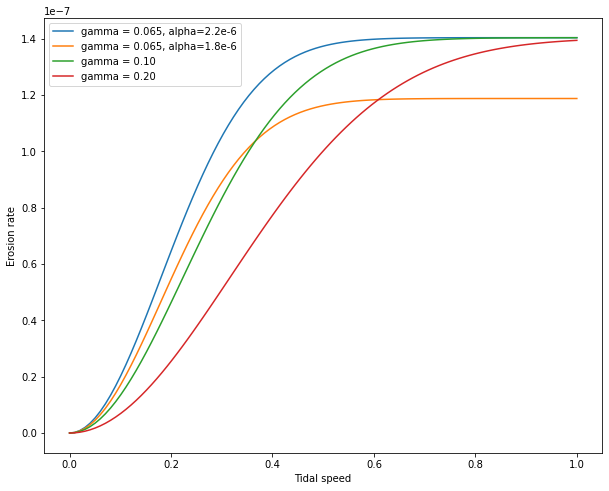

In [61]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(plot_tidal_speed, plot_erosion_rate1, label='gamma = 0.065, alpha=2.2e-6')
ax.plot(plot_tidal_speed, plot_erosion_rate10, label='gamma = 0.065, alpha=1.8e-6')
ax.plot(plot_tidal_speed, plot_erosion_rate2, label='gamma = 0.10')
ax.plot(plot_tidal_speed, plot_erosion_rate3, label='gamma = 0.20')
ax.set_xlabel('Tidal speed')
ax.set_ylabel('Erosion rate')
ax.legend()

Constants:

In [17]:
print(f'total constant is {alpha_0*gamma}, which is C*alpha_0*gamma')
print(f'so, C*gamma is {alpha_0*gamma/0.65} with alpha_0 is 0.65')
print(f'gamma is {gamma}, so C is {alpha_0/0.65}')

total constant is 1.188e-07, which is C*alpha_0*gamma
so, C*gamma is 1.8276923076923077e-07 with alpha_0 is 0.65
gamma is 0.065, so C is 2.8118343195266275e-06


In [18]:
i1, j1 = find_index_ANHA12([-127.09,-123.43], [71.51, 70.66]) #Magen et al., 2010
i2, j2 = find_index_ANHA12([-127.315, -128.745, -134.485, -138.613], [70.766, 71.479, 70.962, 69.971]) #O'Brien et al, 2006
i3, j3 = find_index_ANHA12([-101.8078, -101.8032, -101.7986], [68.2411, 68.2470, 68.2425]) #Dezutter et al., 2020

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


$ resuspension = 1 - e^{-v^2} \approx 1 - (1 - v^2) = v^2$

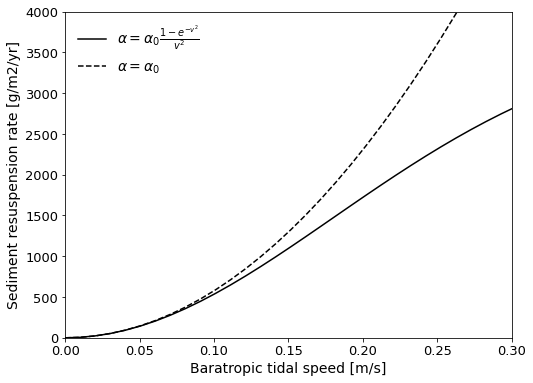

In [19]:
tide           = np.linspace(0,1,100)
resus_rate     = alpha_0*gamma*(1-np.exp(-(tide)**2/gamma))*3600*24*365*1e3
old_resus_rate = alpha_0*(tide**2)*3600*24*365*1e3

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(tide, resus_rate, '-k', label=r'$\alpha = \alpha_0\frac{1-e^{-v^2}}{v^2}$')
ax.plot(tide, old_resus_rate, '--k', label=r'$\alpha = \alpha_0$')
# ax.plot([0.03], [35], '*', markersize=10, label='Forest et al., 2010')
# Only know some of the lats and lons specifically, read the rest off the plots based on approximate location.
# ax.plot([0.03, 0.02, 0.03, 0.03, 0.03 ,tidal_speed_ANHA12[int(i1[0]), int(j1[0])], \
#          0.02, tidal_speed_ANHA12[int(i1[1]), int(j1[1])]], \
#         np.array([0.718, 0.323, 0.182, 0.074, 0.147, 0.058, 0.129, 0.144])*365, \
#         '*', markersize=10, label='Magen et al., 2010') # convert from mg/day to mg/yr. 
# ax.plot([tidal_speed_ANHA12[int(i2[n]), int(j2[n])] for n in range(0,len(i2))], \
#         [108, 53, 20, 140], '*', markersize=10, label='O\'Brien et al., 2006')
# ax.plot([tidal_speed_ANHA12[int(i3[n]), int(j3[n])] for n in range(0,len(i3))], \
#         [287, 243, 290], '*', markersize=10, label='Dezutter et al., 2020')
ax.set_xlim([0, 0.3])
ax.set_ylim([0,4e3])
ax.set_xlabel('Baratropic tidal speed [m/s]', fontsize=14)
ax.set_ylabel('Sediment resuspension rate [g/m2/yr]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)

ax.legend(fontsize=14, frameon=False)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202104/A8-tail-off.png', bbox_inches='tight')

## Plots

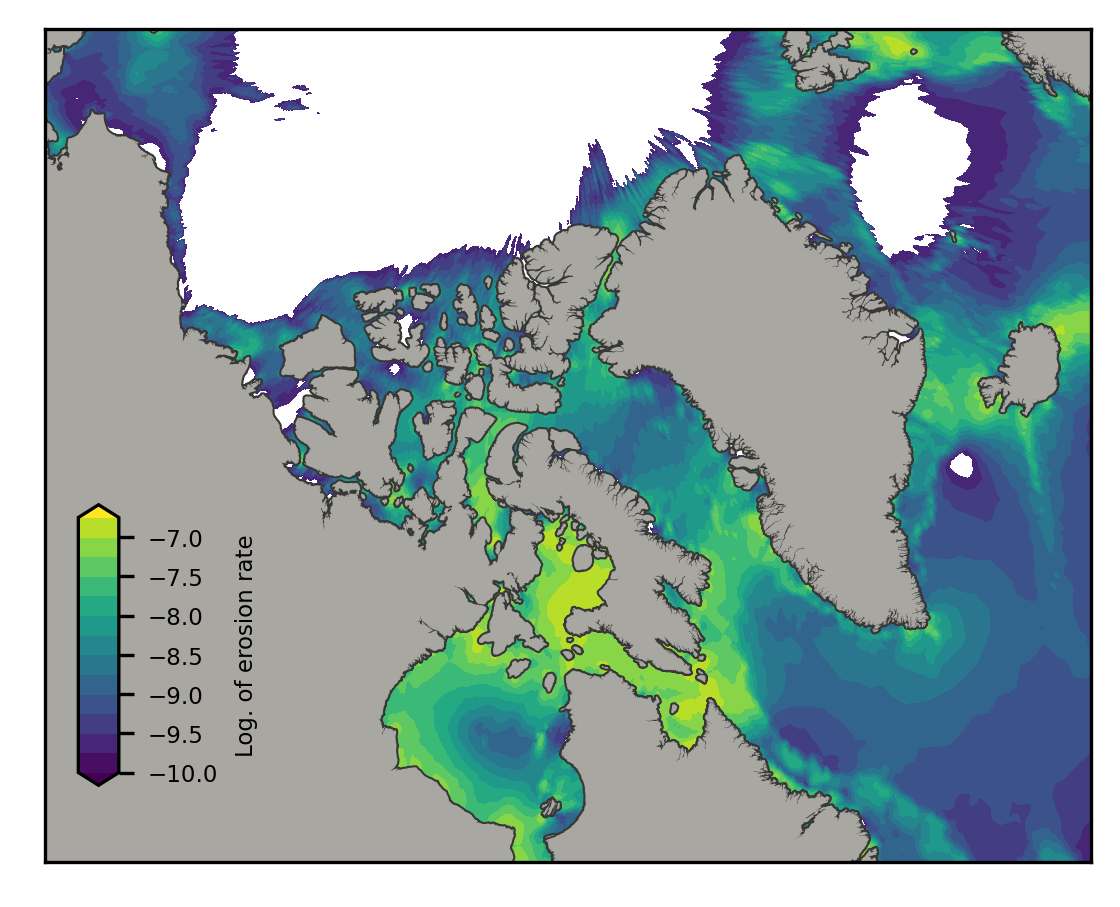

In [22]:
fig, ax1, proj1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# tidal stress:
CB = proj1.contourf(x_sub, y_sub, log_new_erosion_rate, vmin=-10, vmax=-6.5, \
                    levels=np.arange(-10,-6.5,0.25), extend='both')

cbaxes = fig.add_axes([0.15, 0.20, 0.03, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes, ticks=np.arange(-10,-6.5,0.5))
CBar.ax.tick_params(labelsize=5.5)
CBar.set_label('Log. of erosion rate', fontsize=5.5)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/resuspension-new.png', bbox_inches='tight')

In [23]:
print('Units [g/m2/yr]')
print('Average erosion rate in domain: ', np.average(new_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)
print('Maximum erosion rate in domain: ', np.amax(new_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)
print('Minimum erosion rate in domain: ', np.amin(new_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)

print('Units [g/m2/yr]')
print('Average erosion rate in domain: ', np.average(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)
print('Maximum erosion rate in domain: ', np.amax(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)
print('Minimum erosion rate in domain: ', np.amin(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)

Units [g/m2/yr]
Average erosion rate in domain:  322.9851258003181
Maximum erosion rate in domain:  3746.476799245633
Minimum erosion rate in domain:  0.0
Units [g/m2/yr]
Average erosion rate in domain:  623.8899586941111
Maximum erosion rate in domain:  83643.68167750213
Minimum erosion rate in domain:  0.0


# Write to file:

In [24]:
file_write = xr.Dataset(
    {'er_rate': (("y","x"), new_erosion_rate)}, 
    coords = {
        "y": np.zeros(2400),
        "x": np.zeros(1632),
    },
    attrs = {
        'long_name':'Erosion rate',
        'units':'kg/m2/s',
    }
)

In [25]:
file_write.to_netcdf('/ocean/brogalla/GEOTRACES/data/erosion_rate-pb-scavenging.nc')